# Fine-tune Multi-Genre Natural Language Inference on Amazon Shopping Query Dataset

## Check out GPU Type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 30 14:45:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Check out RAM Size

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [3]:
! pip install -q datasets transformers

     |████████████████████████████████| 325 kB 14.0 MB/s 
     |████████████████████████████████| 4.0 MB 67.8 MB/s 
     |████████████████████████████████| 1.1 MB 83.9 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 212 kB 94.0 MB/s 
     |████████████████████████████████| 136 kB 88.2 MB/s 
     |████████████████████████████████| 127 kB 85.7 MB/s 
     |████████████████████████████████| 6.6 MB 71.2 MB/s 
     |████████████████████████████████| 895 kB 77.5 MB/s 
     |████████████████████████████████| 596 kB 88.1 MB/s 
     |████████████████████████████████| 144 kB 48.5 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 80.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which 

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [4]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Then you need to install Git-LFS. Uncomment the following instructions:

In [5]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [6]:
import transformers

print(transformers.__version__)

4.18.0


# Fine-tuning a model on a text classification task

This notebook is built to run on MNLI task, with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a classification head. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [7]:
model_checkpoint = "nlptown/bert-base-multilingual-uncased-sentiment"
#model_checkpoint = "distilbert-base-uncased"
#model_checkpoint = "bert-base-cased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to load the data from the disc and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [8]:
from datasets import load_dataset, load_metric, list_metrics

## We can directly pass our task name to those functions. `load_dataset` will cache the dataset to avoid downloading it again the next time you run this cell.

In [9]:
actual_task = "mnli"
metric = load_metric('glue', actual_task)

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

## Mount the Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

% cd /content/drive/MyDrive/bigdata/final/data/archive

Mounted at /content/drive
/content/drive/MyDrive/bigdata/final/data/archive


## Read in Amazon Shopping Query dataset

In [11]:
import datasets
import random
import pandas as pd
import numpy as np

path = ['amazon_reviews_us_Apparel_v1_00.tsv',
        'amazon_reviews_us_Automotive_v1_00.tsv',
        'amazon_reviews_us_Baby_v1_00.tsv',
        'amazon_reviews_us_Beauty_v1_00.tsv',
        'amazon_reviews_us_Books_v1_02.tsv',
        'amazon_reviews_us_Camera_v1_00.tsv',
        'amazon_reviews_us_Electronics_v1_00.tsv',
        'amazon_reviews_us_Furniture_v1_00.tsv',
        'amazon_reviews_us_Sports_v1_00.tsv',
        'amazon_reviews_us_Grocery_v1_00.tsv',
        'amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv',
        'amazon_reviews_us_Music_v1_00.tsv']

li = []
num_each = 2000

for filename in path:
    df = pd.read_csv(filename, index_col=None, header=0, sep="\t", error_bad_lines=False, warn_bad_lines=False)
    df = df.sample(n=num_each)
    li.append(df)

product = pd.concat(li, axis=0, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
product

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,23581415,R2JYRPSMRW2DTQ,B0062AND7O,97080488,Sutton Studio Womens Plaid Reversible Cape Jac...,Apparel,4.0,1.0,1.0,N,Y,I liked the weight and the fabric so for a lar...,I was really excited about this coat and wante...,2014-12-14
1,US,31667034,R363LE28SHYLZC,B004DIOW3G,451456675,Avia Womens A5015 White/Grey/Light Pink Synthe...,Apparel,4.0,0.0,0.0,N,Y,Good shoe for the price,I purchased this as a running shoe because I w...,2013-01-08
2,US,15253351,R31ZE6DU6Z7VHC,B00S7FR8R8,970402208,PUMA Little Boys' Swift Performance Two-Piece Set,Apparel,3.0,0.0,0.0,N,Y,Abrasive embroidery caution,The back of the shirt has an embroidered puma...,2015-05-18
3,US,42401454,R38S3GK84UHWRG,B008LXYUSQ,694348975,Seaboard Surf Wear Men's Swim Trunks,Apparel,4.0,0.0,0.0,N,Y,Nicer than expected,They fit as expected and look fine. They also...,2013-08-10
4,US,34768865,RLTGWGBVN6ZPR,B001SN7Q1Y,537792752,Impact Men's Pink Floyd Dark Side Of The Moon ...,Apparel,5.0,0.0,0.0,N,Y,Rad!,Fits perfect. Always gets a head nod or compli...,2013-09-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,US,3541847,RADCZKLJWWK52,B00004YLAO,470722871,Introduce Yourself,Music,5.0,0.0,0.0,N,Y,I instantly fell in love with the record as I ...,"I first purchased this disc in 1991, shortly a...",2015-05-06
23996,US,48436214,R3GJOSAP8C4F7Z,B00B671THO,313384665,Just Feels Good,Music,5,0.0,0.0,N,Y,My husband wanted it.,My husband heard one of the songs on the radio...,2013-10-12
23997,US,29370180,R1VH4QJOX3ETS4,B00000399X,962279432,Beasts of Scotland,Music,5.0,4.0,4.0,N,Y,Unexpected Treasure,This collection succeeds in doing what Gunther...,2011-04-23
23998,US,35642363,RGHRF4KMSGBPV,B00RXPTW7W,256979922,All American Boy,Music,5.0,19.0,19.0,N,N,Amazing Debut Album by Steve Grand! Something ...,"This is an amazing album, with something for e...",2015-03-23


In [13]:
product['review'] = product['review_headline'] + ". " + product['review_body']
product = product[['review', 'star_rating']]
product = product.rename(columns={'review': 'text', 'star_rating': 'label'})
alled = product

## Split the data into training, validation, test and downsample it for training

In [14]:
from sklearn.model_selection import train_test_split

frac_train = 0.9
frac_test = 0.8

train_all, test = train_test_split(alled, train_size=frac_train, shuffle=True)
train, dev = train_test_split(train_all, train_size=frac_test, shuffle=True)

train = train.dropna()
dev = dev.dropna()
test = test.dropna()
print('Before training shape:',train.shape)
print('Before dev shape:',dev.shape)
print('Before test shape:',test.shape)

'''
train = train.sample(n=train_count)
dev = dev.sample(n=dev_count)
test = test.sample(n=test_count)

print('After training shape:',train.shape)
print('After dev shape:',dev.shape)
print('After test shape:',test.shape)
'''

train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train = train.astype({'label': int})
dev = dev.astype({'label': int})
test = test.astype({'label': int})

train['label'] = train['label'] - 1
dev['label'] = dev['label'] - 1
test['label'] = test['label'] - 1

# Save each data
train.to_csv("../tune/train.csv", index=False)
dev.to_csv("../tune/dev.csv", index=False)
test.to_csv("../tune/test.csv", index=False)

Before training shape: (17280, 2)
Before dev shape: (4320, 2)
Before test shape: (2400, 2)


## load_dataset the train, validation, test from the disc

In [15]:
dataset = load_dataset("csv", data_files={'train': '../tune/train.csv', 'validation': '../tune/dev.csv', 'test': '../tune/test.csv'})

Using custom data configuration default-993eebaf23500e9d


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-993eebaf23500e9d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## To access an actual element, you need to select a split first, then give an index:

In [16]:
dataset["train"][20]

{'label': 4,
 'text': "A voice like honey &amp; rose water. I'm a Fairuz fan, so somewhat biased..........but this is a wonderful album. Her voice is wonderfully dramatic &amp; sweet."}

## To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

## The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [17]:
from transformers import AutoTokenizer

print(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

nlptown/bert-base-multilingual-uncased-sentiment


Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

We can double check it does work on our current dataset:

### We can them write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.

In [18]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

### To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [19]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels):

In [20]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

print(model_checkpoint)
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

nlptown/bert-base-multilingual-uncased-sentiment


Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. **It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:**

In [21]:
metric_name = "accuracy"
print(metric_name)
model_name = model_checkpoint.split("/")[-1]
print(model_name)

args = TrainingArguments(
    f"{model_name}-finetuned-{actual_task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

accuracy
bert-base-multilingual-uncased-sentiment


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

## Define our `Trainer`
The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

## Then we just need to pass all of this along with our datasets to the `Trainer`:

In [23]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/content/drive/MyDrive/bigdata/final/data/archive/bert-base-multilingual-uncased-sentiment-finetuned-mnli is already a clone of https://huggingface.co/LiYuan/bert-base-multilingual-uncased-sentiment-finetuned-mnli. Make sure you pull the latest changes with `repo.git_pull()`.


You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

# We can now finetune our model by just calling the `train` method:

In [24]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 17280
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2160


Epoch,Training Loss,Validation Loss,Accuracy
1,0.555400,0.520294,0.800000
2,0.424300,0.549649,0.798380


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4320
  Batch size = 16
Saving model checkpoint to bert-base-multilingual-uncased-sentiment-finetuned-mnli/checkpoint-1080
Configuration saved in bert-base-multilingual-uncased-sentiment-finetuned-mnli/checkpoint-1080/config.json
Model weights saved in bert-base-multilingual-uncased-sentiment-finetuned-mnli/checkpoint-1080/pytorch_model.bin
tokenizer config file saved in bert-base-multilingual-uncased-sentiment-finetuned-mnli/checkpoint-1080/tokenizer_config.json
Special tokens file saved in bert-base-multilingual-uncased-sentiment-finetuned-mnli/checkpoint-1080/special_tokens_map.json
tokenizer config file saved in bert-base-multilingual-uncased-sentiment-finetuned-mnli/tokenizer_conf

TrainOutput(global_step=2160, training_loss=0.49806432017573604, metrics={'train_runtime': 1176.5855, 'train_samples_per_second': 29.373, 'train_steps_per_second': 1.836, 'total_flos': 9093363003555840.0, 'train_loss': 0.49806432017573604, 'epoch': 2.0})

## We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [25]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4320
  Batch size = 16


{'epoch': 2.0,
 'eval_accuracy': 0.8,
 'eval_loss': 0.5202942490577698,
 'eval_runtime': 45.227,
 'eval_samples_per_second': 95.518,
 'eval_steps_per_second': 5.97}

## Evaluate our best trained model on held-out test set

In [26]:
predictions = trainer.predict(encoded_dataset["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)
metric.compute(predictions=preds, references=predictions.label_ids)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2400
  Batch size = 16


(2400, 5) (2400,)


{'accuracy': 0.7745833333333333}

## F1 score on the held-test set

In [27]:
from sklearn.metrics import f1_score

f1_score(y_true=predictions.label_ids, y_pred=preds, average='weighted')

0.7573346348413283

## Plot a confusion matrix on the held-out test set

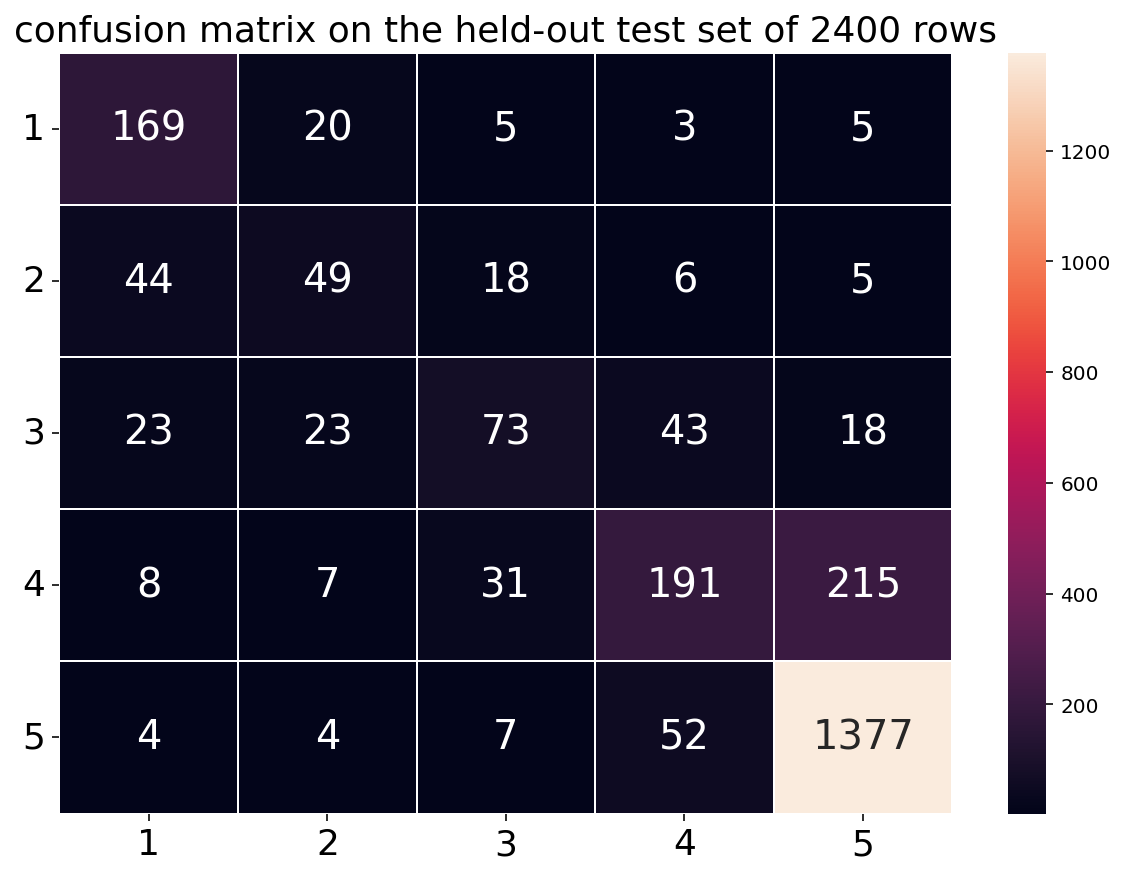

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

array = confusion_matrix(y_true=predictions.label_ids, y_pred=preds)

df_cm = pd.DataFrame(array, index = [i for i in [1,2,3,4,5]],
                  columns = [i for i in [1,2,3,4,5]])

plt.figure(figsize = (10,7))
ax = plt.axes()
g = sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax, annot_kws={"size": 20});
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 18)
g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 18)
ax.set_title(f'confusion matrix on the held-out test set of {len(preds)} rows', fontsize=18)
plt.show()

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

In [ ]:
model.push_to_hub("https://huggingface.co/LiYuan/distilbert-base-uncased-finetuned-mnli")

## Reload our best model from the disc and test it

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

path = "/content/drive/MyDrive/sna/distilbert-base-uncased-finetuned-mnli"

model = AutoModelForSequenceClassification.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path)

features = tokenizer([dataset["test"][0]['premise'], dataset["test"][1]['premise']], [dataset["test"][0]['hypothesis'], dataset["test"][1]['hypothesis']],  padding=True, truncation=True, return_tensors="pt")

model.eval()
with torch.no_grad():
    scores = model(**features).logits
    print(scores)

loading configuration file /content/drive/MyDrive/sna/distilbert-base-uncased-finetuned-mnli/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/sna/distilbert-base-uncased-finetuned-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading weights

tensor([[ 2.4494, -0.0620, -2.0296, -1.4261],
        [ 2.9035,  0.4867, -3.1780, -1.1103]])


## Hyperparameter search

The `Trainer` supports hyperparameter search using [optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/). For this last section you will need either of those libraries installed, just uncomment the line you want on the next cell and run it.

In [ ]:
! pip install -q optuna
! pip install -q ray[tune]

     |████████████████████████████████| 308 kB 13.2 MB/s 
     |████████████████████████████████| 81 kB 11.8 MB/s 
     |████████████████████████████████| 210 kB 99.1 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 146 kB 97.3 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 113 kB 93.2 MB/s 
     |████████████████████████████████| 53.2 MB 1.1 MB/s 
     |████████████████████████████████| 4.1 MB 96.9 MB/s 
     |████████████████████████████████| 8.8 MB 71.2 MB/s 
     |████████████████████████████████| 125 kB 89.0 MB/s 
     |████████████████████████████████| 461 kB 99.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


During hyperparameter search, the `Trainer` will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

And we can instantiate our `Trainer` like before:

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"].shard(index=1, num_shards=50000),
    eval_dataset=encoded_dataset['validation'].shard(index=1, num_shards=100),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0

The method we call this time is `hyperparameter_search`. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the `train_dataset` line above by:
```python
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 
```
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2022-04-27 16:20:15,705] A new study created in memory with name: no-name-79bf5d83-712d-451b-bfad-6ff0059bf89c
Trial:
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.378575,0.310000
2,No log,1.373592,0.310000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/run-0/checkpoint-1
Configuration saved in distilbert-base-uncased-finetuned-mnli/run-0/checkpoint-1/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/run-0/checkpoint-1/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/run-0/checkpoint-1/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/run-0/checkpoint-1/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/tokenizer_config.json
Special tokens file saved in

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.344183,0.440000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/run-1/checkpoint-1
Configuration saved in distilbert-base-uncased-finetuned-mnli/run-1/checkpoint-1/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/run-1/checkpoint-1/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/run-1/checkpoint-1/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/run-1/checkpoint-1/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.322719,0.450000
2,No log,1.292867,0.450000
3,No log,1.276717,0.450000
4,No log,1.270632,0.450000
5,No log,1.269595,0.450000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/run-2/checkpoint-1
Configuration saved in distilbert-base-uncased-finetuned-mnli/run-2/checkpoint-1/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/run-2/checkpoint-1/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/run-2/checkpoint-1/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/run-2/checkpoint-1/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.320306,0.450000
2,No log,1.280311,0.450000
3,No log,1.266729,0.450000
4,No log,1.269339,0.450000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/run-3/checkpoint-2
Configuration saved in distilbert-base-uncased-finetuned-mnli/run-3/checkpoint-2/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/run-3/checkpoint-2/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/run-3/checkpoint-2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/run-3/checkpoint-2/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.372841,0.310000
2,No log,1.365902,0.395000
3,No log,1.361123,0.435000
4,No log,1.358037,0.445000
5,No log,1.356892,0.445000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/run-4/checkpoint-3
Configuration saved in distilbert-base-uncased-finetuned-mnli/run-4/checkpoint-3/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/run-4/checkpoint-3/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/run-4/checkpoint-3/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/run-4/checkpoint-3/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.286872,0.450000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/run-5/checkpoint-1
Configuration saved in distilbert-base-uncased-finetuned-mnli/run-5/checkpoint-1/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/run-5/checkpoint-1/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/run-5/checkpoint-1/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/run-5/checkpoint-1/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.375113,0.375000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
[I 2022-04-27 16:22:13,387] Trial 6 pruned. 
Trial:
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LA

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.361079,0.360000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
[I 2022-04-27 16:22:17,162] Trial 7 pruned. 
Trial:
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LA

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.269742,0.450000
2,No log,1.326423,0.450000
3,No log,1.362383,0.450000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/run-8/checkpoint-2
Configuration saved in distilbert-base-uncased-finetuned-mnli/run-8/checkpoint-2/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/run-8/checkpoint-2/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/run-8/checkpoint-2/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/run-8/checkpoint-2/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.415843,0.165000


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
[I 2022-04-27 16:22:36,995] Trial 9 pruned. 


The `hyperparameter_search` method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [ ]:
best_run

BestRun(run_id='2', objective=0.45, hyperparameters={'learning_rate': 4.6463756078135e-05, 'num_train_epochs': 5, 'seed': 39, 'per_device_train_batch_size': 32})

You can customize the objective to maximize by passing along a `compute_objective` function to the `hyperparameter_search` method, and you can customize the search space by passing a `hp_space` argument to `hyperparameter_search`. See this [forum post](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10) for some examples.

To reproduce the best training, just set the hyperparameters in your `TrainingArgument` before creating a `Trainer`:

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467531,0.446775
2,0.428433,0.476509,0.521516


TrainOutput(global_step=536, training_loss=0.4191349371155696)